In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import pandas as pd 
import time
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.modules import linear
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import optim 
from collections import defaultdict
import pickle 
from matplotlib import pyplot as plt 
import time

In [2]:
cd /content/drive/MyDrive/Project3 

/content/drive/MyDrive/Project3


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv3 = nn.Conv2d(64, 128, 5, 1)
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv4 = nn.Conv2d(128, 256, 5, 1)
        self.pool4 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv5 = nn.Conv2d(256, 256, 5, 1)
        self.pool5 = nn.MaxPool2d(kernel_size=2,stride=2)


        self.dropout1 = nn.Dropout(0.1)


        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        data = []
        x1 = self.conv1(x)
        data.append(x1)
        x1 = nn.functional.normalize(x1)
        x1 = self.pool1(F.relu(x1))
        x1 = self.dropout1(x1)

        x2 = self.conv2(x1)
        data.append(x2)
        x2 = nn.functional.normalize(x2)
        x2 = self.pool2(F.relu(x2))
        x2 = self.dropout1(x2)

        x3 = self.conv3(x2)
        data.append(x3)
        x3 = nn.functional.normalize(x3)
        x3 = self.pool3(F.relu(x3))
        x3 = self.dropout1(x3)

        x4 = self.conv4(x3)
        data.append(x4)
        x4 = nn.functional.normalize(x4)
        x4 = self.pool4(F.relu(x4))
        x4 = self.dropout1(x4)

        x5 = self.conv5(x4)
        data.append(x5)
        x5 = nn.functional.normalize(x5)
        x5 = self.pool5(F.relu(x5))
        x5 = self.dropout1(x5)

        x6 = torch.flatten(x5, 1)
        # print(x6.shape)

        out = self.fc1(x6)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        output = self.logSoftmax(out)
        return output,data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
net = Net().to(device)
net_optimizer = optim.Adam(lr=0.001,params= net.parameters())

Load model

In [5]:
def load_data_train(net):
    checkPointModel = torch.load('weights/bestModel.pth')
    net.load_state_dict(checkPointModel['model_state_dict'])

In [6]:
load_data_train(net)

Loading data

In [7]:
X_train = torch.load('datasets/X_train')
X_test = torch.load('datasets/X_test')
y_train = torch.load('datasets/y_train')
y_test = torch.load('datasets/y_test')
X_val = torch.load('datasets/X_val')
y_val = torch.load('datasets/y_val')

In [8]:
def convertDataloader(X1,y_train):
    batch_size = 64
    train_data = TensorDataset(X1,y_train)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader,train_data

In [9]:
def setDataloader(X_train,X_test,y_train,y_test,X_val,y_val):
    X1_train = torch.tensor(X_train)
    X1_test = torch.tensor(X_test)
    X1_val = torch.tensor(X_val)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)
    y_val = torch.tensor(y_val)

    train_dataloader,train_data = convertDataloader(X1_train,y_train)
    test_dataloader,test_data = convertDataloader(X1_test,y_test)
    val_dataloader,val_data = convertDataloader(X1_val,y_val)
    return train_data,test_data,val_data

In [10]:
train_data,test_data,val_data = setDataloader(X_train,X_test,y_train,y_test,X_val,y_val)

In [11]:
def transform(data):
  trans = transforms.Compose([
            transforms.Resize([224, 224])
        ])
  return trans(data)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshowImage(data):
    img = data.detach().clone()
    # for x in range(3):
    #     img[x] = img[x]*std[x] + mean[x]
    # img = transform(img) # resize (32,32)
    
    npimg = img.numpy()
    npimg = npimg.reshape(28,28)
    plt.imshow(npimg,cmap='gray')
    plt.show()

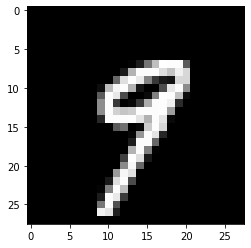

In [17]:
imshowImage(train_data[7][0])

In [18]:
def visual(model,index):
    model.eval()
    input_size = train_data[0][0].shape[1]
    with torch.no_grad():
        input = train_data[index][0]
        x = input.reshape(1,1,input_size,input_size)
        outs,data = model(x.to(device))
    return input,data,train_data[index][1].item()

In [19]:
input,data_need,lable = visual(net,0)

In [20]:
weights = net.state_dict()

In [21]:
from matplotlib.pyplot import figure
def visualData(input,max = 64):
    f = (input - input.min())/(input.max()-input.min() + 1e-9 )

    figure(figsize=(18, 18), dpi=100)
    dim0 = f.shape[0]
    if dim0 > max:
        dim0 = max
    for i in range(dim0):
        image = f[i]
        plt.subplot(dim0/4+1,4,i+1)
        plt.imshow(image,cmap='gray')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

In [22]:
from matplotlib.pyplot import figure
def saveImage(input,type,lable,layer,max = 64):
    f = (input - input.min())/(input.max()-input.min() + 1e-9 )

    figure(figsize=(18, 18), dpi=100)
    dim0 = f.shape[0]
    if dim0 > max:
        dim0 = max
    for i in range(dim0):
        image = f[i]
        plt.imshow(image,cmap='gray')
        path = 'Image/'+type+'/'+str(lable)+'_'+str(i)+'_layer'+str(layer)+'.png'
        print('Save file')
        plt.savefig(path)

Visulization of layer 01

In [ ]:
filterConv1 = weights['conv1.weight']
filterConv1 = np.array(filterConv1.cpu())
visualData(filterConv1[0]) # filter thứ 1 của conv1
saveImage(filterConv1[0],'Filter',lable,1)

Visulization of layer 02

In [ ]:
filterConv2 = weights['conv2.weight']
filterConv2 = np.array(filterConv2.cpu())
visualData(filterConv2[0][:3]) # filter thứ 1 của conv2
saveImage(filterConv2[0][:3],'Filter',lable,2)

Visulization of layer 03

In [ ]:
filterConv3 = weights['conv3.weight']
filterConv3 = np.array(filterConv3.cpu())
visualData(filterConv3[0][:3]) # filter thứ 1 của conv3
saveImage(filterConv3[0][:3],'Filter',lable,3)

Visulization of layer 04

In [ ]:
filterConv4 = weights['conv4.weight']
filterConv4 = np.array(filterConv4.cpu())
visualData(filterConv4[0][:3]) # filter thứ 1 của conv4
saveImage(filterConv4[0][:3],'Filter',lable,4)

Visulization of layer 05

Save file
Save file
Save file


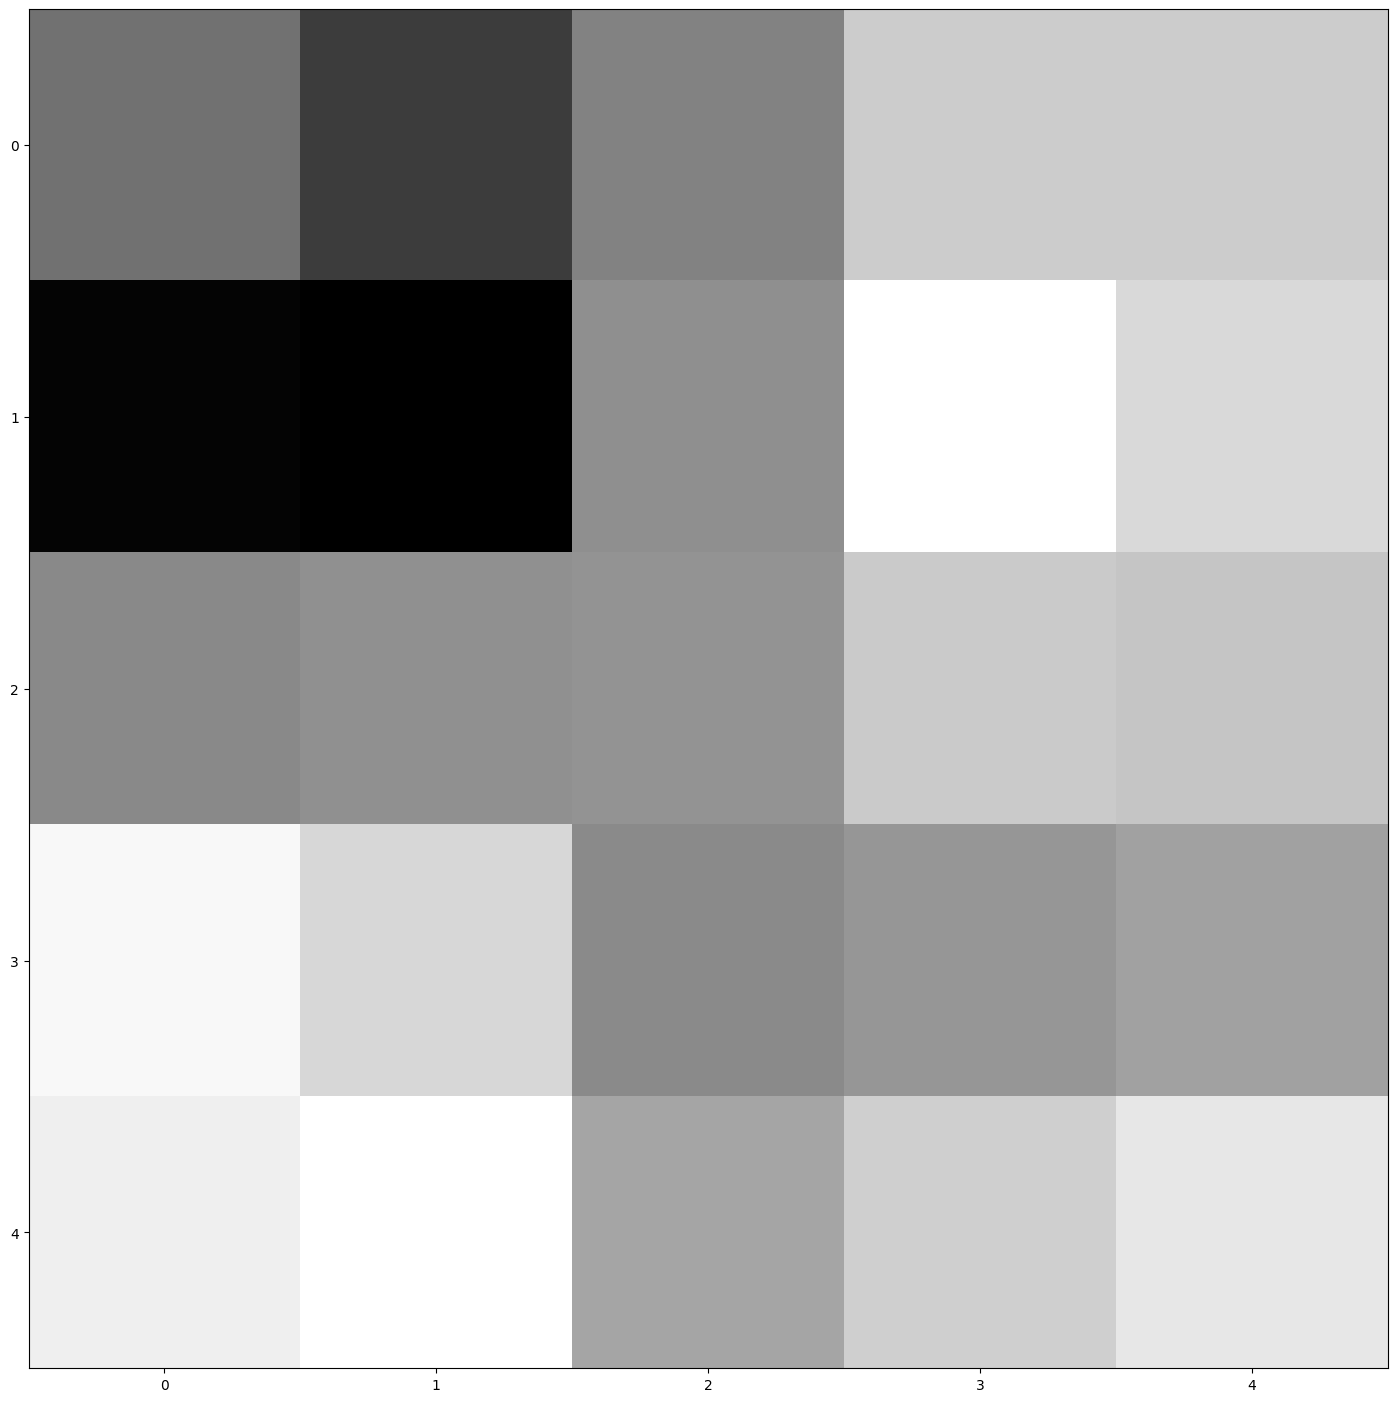

In [40]:
filterConv5 = weights['conv5.weight']
filterConv5 = np.array(filterConv5.cpu())
# visualData(filterConv5[0]) # filter thứ 1 của conv5
saveImage(filterConv5[0][:3],'Filter',lable,5)

Original image

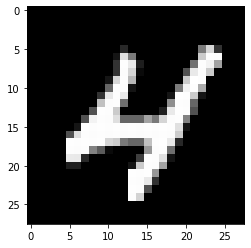

In [41]:
imshowImage(input)

In [42]:
dataVisual = [x.cpu() for x in data_need]

Layer 1: 32 Conv (3,3)

In [ ]:
visualData(dataVisual[0][0][:3])
saveImage(dataVisual[0][0][:3],'Output',lable,1)

Layer 2: 64 Conv (3,3)

In [ ]:
visualData(dataVisual[1][0][:3])
saveImage(dataVisual[1][0][:3],'Output',lable,2)

Layer 3: 128 Conv (5,5)

In [ ]:
visualData(dataVisual[2][0][:3])
saveImage(dataVisual[2][0][:3],'Output',lable,3)

Layer 4: 256 Conv (5,5)

In [ ]:
visualData(dataVisual[3][0][:3])
saveImage(dataVisual[3][0][:3],'Output',lable,4)

Layer 5: 256 Conv (5,5)

In [ ]:
visualData(dataVisual[4][0][:3])
saveImage(dataVisual[4][0][:3],'Output',lable,5)